### hi_res_grid_tiff2nc
Script to read in `.tif` files exported from Global Mapper and write `.nc` files

The input `.tif` files were exported in UTM Zone 18N, NAVD88 coordinates for a specific bounding box
outlining a high-resolution region that CRS and CAH chose on June 4, 2021. The GM project is
`..\proj\2019_DorianOBX\High_res_grid.gmw`.  

Coordinates for the elevation matrices were converted to island coordinates and lat/lon using routines in `CoreBx_funcs`.

This version writes *raw* data, with no bias corrections, smoothing, or hole filling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
from scipy import interpolate, signal
import netCDF4 as nc
from CoreBx_funcs import *
import pickle

%matplotlib inline

vegmap= cm.get_cmap('YlGn')
vegmap.set_bad(color='darkgray')

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

In [2]:
fdir = "C:/crs/proj/2021_hi_res_grid/"
fnames = ("2019-08-30_1m_DEM_4d_hr.tif",
          "2019-09-12-13_1m_DEM_4d_hr.tif",
          "2019-10-11_1m_DEM_4d_hr.tif",
          "2019-11-26_1m_DEM_4d_hr.tif",
          "2019_NCMP_gnd_50_1m_hr.tif",
          "2019_NCMP_1st95_1m_hr.tif",
          "2019_NCMP_Veg_1st95_minus_gnd_50_1m_hr.tif",
)
mnames = ("Aug SfM",
          "Sep SfM",
          "Oct SfM",
          "Nov SfM",
          "Nov Lidar Gnd50",
          "Nov Lidar First95",
          "Nov Lidar Diff")

fnnc = 'C:/crs/proj/2019_DorianOBX/NCEI_gridded_bathy/morehead_city_13_navd88_2011.nc'
# ds = nc.Dataset(fnnc)
# print(ds)

# dimension array for elevations
z = np.nan*np.ones((7, 1685, 1627))
print(np.shape(z))

(7, 1685, 1627)


In [3]:
dslist=[]
for i, fn in enumerate(fnames):
    iswarned = False
    fp = fdir+fn
    print(i, fp)

    # open the tif with XArray as a DataArray
    da = xr.open_rasterio(fp)

    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)

    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z[i,:,:] = np.flipud(np.squeeze(da.values))
  

0 C:/crs/proj/2021_hi_res_grid/2019-08-30_1m_DEM_4d_hr.tif
(1685,) (1627,) (1, 1685, 1627)
1 C:/crs/proj/2021_hi_res_grid/2019-09-12-13_1m_DEM_4d_hr.tif
(1685,) (1627,) (1, 1685, 1627)
2 C:/crs/proj/2021_hi_res_grid/2019-10-11_1m_DEM_4d_hr.tif
(1685,) (1627,) (1, 1685, 1627)
3 C:/crs/proj/2021_hi_res_grid/2019-11-26_1m_DEM_4d_hr.tif
(1685,) (1627,) (1, 1685, 1627)
4 C:/crs/proj/2021_hi_res_grid/2019_NCMP_gnd_50_1m_hr.tif
(1685,) (1627,) (1, 1685, 1627)
5 C:/crs/proj/2021_hi_res_grid/2019_NCMP_1st95_1m_hr.tif
(1685,) (1627,) (1, 1685, 1627)
6 C:/crs/proj/2021_hi_res_grid/2019_NCMP_Veg_1st95_minus_gnd_50_1m_hr.tif
(1685,) (1627,) (1, 1685, 1627)


In [4]:
# Nans come through as -32767 
ibadz = np.where(z<=-32767.)
z[ibadz] = np.nan

In [5]:
# test UTM2LatLon
# Coordinates of test point CHL2 (benchmark near the Cape Hatteras light)
# NAD 83(2011) POSITION- 35 15 06.46121(N) 075 31 34.42905(W)   ADJUSTED 
# UTM  18      - 3,901,093.616   452,127.951   MT  0.99962824   -0 18 13.4

latbm = 35.+15./60.+6.46121/3600.
lonbm = -(75.+31/60.+34.42905/3600.)
# The extra decimals in the next line come from the reverse transformation
lont, latt = UTM2LatLon(452127.9512561703, 3901093.6160874437 )
print(latt, lont)
print(latbm,lonbm)

35.251794780555564 -75.52623029166666
35.25179478055556 -75.52623029166666


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [6]:
east, north = np.meshgrid(x,y)
xisl, yisl = UTM2Island(east,north)
lond, latd = UTM2LatLon(east, north)

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


x: (1627,) 
 [394084.42627824 394085.42627824 394086.42627824 ... 395708.42627824
 395709.42627824 395710.42627824]
y: (1685,) 
 [3871151.97458986 3871152.97458986 3871153.97458986 ... 3872833.97458986
 3872834.97458986 3872835.97458986]


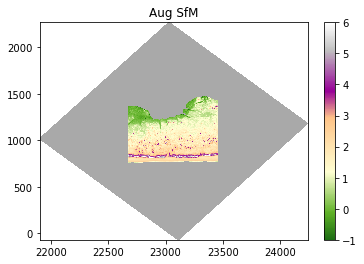

In [7]:
print('x:',np.shape(x),'\n',x)
print('y:',np.shape(y),'\n',y)
mapnum=0
plt.pcolormesh(xisl,yisl,z[mapnum,:,:],cmap=tcmap,vmin=-1,vmax=6)
plt.title(mnames[mapnum])
plt.colorbar()

In [8]:
fno = 'C:/crs/proj/2019_DorianOBX/WayneWright_flights/CoreBx/NCBx_hi_res_raw.nc'
dso = nc.Dataset(fno, 'w', format='NETCDF4')

#time = dso.createDimension('time', None)
xi_rho = dso.createDimension('xi_rho', 1685)
eta_rho = dso.createDimension('eta_rho', 1627)

xi = dso.createVariable('xi', np.float32, (('eta_rho','xi_rho')))
yi = dso.createVariable('yi', np.float32, (('eta_rho','xi_rho')))
xi.units = 'm'
xi.long_name = 'Along-island coordinate'
yi.units = 'm'
yi.long_name = 'Cross-island coordinate'

xi[:,:]=xisl.T
yi[:,:] = yisl.T

lon = dso.createVariable('lon', 'f4', ('eta_rho','xi_rho'))
lat = dso.createVariable('lat', 'f4', ('eta_rho','xi_rho'))
lon.units = 'degrees N'
lat.units = 'degrees E'
lon.crs = 'epsg:4326'
lat.crs = 'epsg:4326'

lon[:,:] = lond.T
lat[:,:] = latd.T

easting = dso.createVariable('easting', 'f4', ('eta_rho','xi_rho'))
northing = dso.createVariable('northing', 'f4', ('eta_rho','xi_rho'))
easting.units = 'm UTM18N'
northing.units = 'm UTM18N'
easting.crs = 'epsg:26918'
northing.crs = 'epsg:26918'

easting[:,:] = east.T
northing[:,:] = north.T

zAug = dso.createVariable('zAug', 'f4', (('eta_rho','xi_rho')))
zAug.units = 'm NAVD88'
zAug.long_name = '2019-08-30_1m_DEM_4d_hr'
zAug[:,:] = z[0,:,:].T

zSep = dso.createVariable('zSep', 'f4', (('eta_rho','xi_rho')))
zSep.units = 'm NAVD88'
zSep.long_name = '2019-09-12-13_1m_DEM_4d_hr'
zSep[:,:] = z[1,:,:].T

zOct = dso.createVariable('zOct', 'f4', (('eta_rho','xi_rho')))
zOct.units = 'm NAVD88'
zOct.long_name = '2019-10-11_1m_DEM_4d_hr'
zOct[:,:] = z[2,:,:].T

zNov = dso.createVariable('zNov', 'f4', (('eta_rho','xi_rho')))
zNov.units = 'm NAVD88'
zNov.long_name = '2019-11-26_1m_DEM_4d_hr'
zNov[:,:] = z[3,:,:].T

zOctLidarGnd = dso.createVariable('zOctLidarGnd', 'f4', (('eta_rho','xi_rho')))
zOctLidarGnd.units = 'm NAVD88'
zOctLidarGnd.long_name = '2019_NCMP_gnd_50_1m_hr'
zOctLidarGnd[:,:] = z[4,:,:].T

zOctLidarFirst = dso.createVariable('zOctLidarFirst', 'f4', (('eta_rho','xi_rho')))
zOctLidarFirst.units = 'm NAVD88'
zOctLidarFirst.long_name = '2019_NCMP_1st95_1m_hr'
zOctLidarFirst[:,:] = z[5,:,:].T

zOctLidarVeg = dso.createVariable('zOctLidarVeg', 'f4', (('eta_rho','xi_rho')))
zOctLidarVeg.units = 'm NAVD88'
zOctLidarVeg.long_name = '2019_NCMP_Veg_1st95_minus_gnd_50_1m_hr'
zOctLidarVeg[:,:] = z[6,:,:].T

dso.close()